In [18]:
#Load Libraries
import numpy as np
import pandas as pd
import matplotlib.pyplot as plt
%matplotlib inline
import seaborn as sns

ModuleNotFoundError: No module named 'mlxtend'

In [2]:
#Load Dataset
RD=pd.read_csv('Raisin_Dataset.csv')
RD.head()

,Area,MajorAxisLength,MinorAxisLength,Eccentricity,ConvexArea,Extent,Perimeter,Class
0,87524,442.246011,253.291155,0.819738,90546,0.758651,1184.040,Kecimen
1,75166,406.690687,243.032436,0.801805,78789,0.684130,1121.786,Kecimen
2,90856,442.267048,266.328318,0.798354,93717,0.637613,1208.575,Kecimen
3,45928,286.540559,208.760042,0.684989,47336,0.699599,844.162,Kecimen
4,79408,352.190770,290.827533,0.564011,81463,0.792772,1073.251,Kecimen


In [4]:
#Show Key Statistics
RD.describe()

,Area,MajorAxisLength,MinorAxisLength,Eccentricity,ConvexArea,Extent,Perimeter
count,900.000000,900.000000,900.000000,900.000000,900.000000,900.000000,900.000000
mean,87804.127778,430.929950,254.488133,0.781542,91186.090000,0.699508,1165.906636
std,39002.111390,116.035121,49.988902,0.090318,40769.290132,0.053468,273.764315
min,25387.000000,225.629541,143.710872,0.348730,26139.000000,0.379856,619.074000
25%,59348.000000,345.442898,219.111126,0.741766,61513.250000,0.670869,966.410750
50%,78902.000000,407.803951,247.848409,0.798846,81651.000000,0.707367,1119.509000
75%,105028.250000,494.187014,279.888575,0.842571,108375.750000,0.734991,1308.389750
max,235047.000000,997.291941,492.275279,0.962124,278217.000000,0.835455,2697.753000


Class Split
Kecimen    450
Besni      450
Name: Class, dtype: int64


Text(0, 0.5, '')

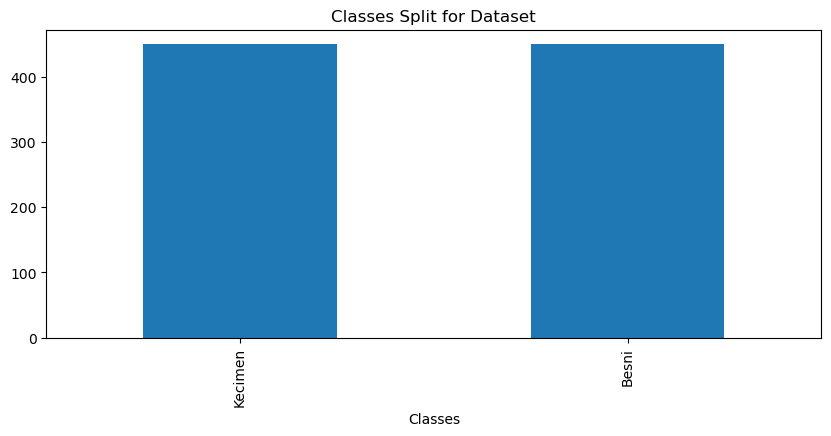

In [8]:
#Class Balance
print('Class Split')
print(RD['Class'].value_counts())
RD['Class'].value_counts().plot.bar(figsize=(10,4),title='Classes Split for Dataset')
plt.xlabel('Classes')
plt.ylabel('')

In [9]:
#Find Independent Column Correlations
def correlation(dataset,threshold):
    col_corr= [] # List of correlated columns
    corr_matrix=dataset.corr() #finding correlation between columns
    for i in range (len(corr_matrix.columns)): #Number of columns
        for j in range (i):
            if abs(corr_matrix.iloc[i,j])>threshold: #checking correlation between columns
                colName=(corr_matrix.columns[i], corr_matrix.columns[j]) #getting correlated columns
                col_corr.append(colName) #adding correlated column name
    return col_corr #returning set of column names
col=correlation(RD,0.8)
print('Correlated columns @ 0.8:', col)

Correlated columns @ 0.8: [('MajorAxisLength', 'Area'), ('MinorAxisLength', 'Area'), ('ConvexArea', 'Area'), ('ConvexArea', 'MajorAxisLength'), ('ConvexArea', 'MinorAxisLength'), ('Perimeter', 'Area'), ('Perimeter', 'MajorAxisLength'), ('Perimeter', 'MinorAxisLength'), ('Perimeter', 'ConvexArea')]


In [11]:
#Define x and y variable
x = RD.drop('Class',axis=1).to_numpy()
y = RD['Class'].to_numpy()

# Create Train and Test Datasets
from sklearn.model_selection import train_test_split
x_train, x_test, y_train, y_test = train_test_split(x, y, test_size=0.20,stratify=y,random_state=100)

#Scale the Data
from sklearn.preprocessing import StandardScaler
sc = StandardScaler()
x_train2 = sc.fit_transform(x_train)
x_test2 = sc.transform(x_test)

#Model
from sklearn.linear_model import LogisticRegression

In [12]:
#Base Logistical Regression Model
from sklearn.metrics import classification_report, confusion_matrix  

for name,method in [('LogReg', LogisticRegression(solver='lbfgs',class_weight='balanced',
                                               random_state=100))]: 
    method.fit(x_train2,y_train)
    predict = method.predict(x_test2)
    print('\nEstimator: {}'.format(name)) 
    print(confusion_matrix(y_test,predict))  
    print(classification_report(y_test,predict))    


Estimator: LogReg
[[76 14]
 [12 78]]
              precision    recall  f1-score   support

       Besni       0.86      0.84      0.85        90
     Kecimen       0.85      0.87      0.86        90

    accuracy                           0.86       180
   macro avg       0.86      0.86      0.86       180
weighted avg       0.86      0.86      0.86       180



In [13]:
#Construct some pipelines 
from sklearn.pipeline import Pipeline
from sklearn.preprocessing import StandardScaler

#Create Pipeline

pipeline =[]

pipe_logreg = Pipeline([('scl', StandardScaler()),
                    ('clf', LogisticRegression(solver='lbfgs',class_weight='balanced',
                                               random_state=100))])
pipeline.insert(0,pipe_logreg)

#Set grid search params 

modelpara =[]

param_gridlogreg = {'clf__C': [0.01, 0.1, 1, 10, 100], 
                    'clf__penalty': ['l2']}
modelpara.insert(0,param_gridlogreg)

In [14]:
#Define Plot for learning curve

from sklearn.model_selection import learning_curve

def plot_learning_curves(model):
    train_sizes, train_scores, test_scores = learning_curve(estimator=model,
                                                            X=x_train, 
                                                            y=y_train,
                                                            train_sizes= np.linspace(0.1, 1.0, 10),
                                                            cv=10,
                                                            scoring='recall_weighted',random_state=100)
    train_mean = np.mean(train_scores, axis=1)
    train_std = np.std(train_scores, axis=1)
    test_mean = np.mean(test_scores, axis=1)
    test_std = np.std(test_scores, axis=1)
    
    plt.plot(train_sizes, train_mean,color='blue', marker='o', 
             markersize=5, label='training recall')
    plt.fill_between(train_sizes, train_mean + train_std, train_mean - train_std,
                     alpha=0.15, color='blue')

    plt.plot(train_sizes, test_mean, color='green', linestyle='--', marker='s', markersize=5,
             label='validation recall')
    plt.fill_between(train_sizes, test_mean + test_std, test_mean - test_std,
                     alpha=0.15, color='green')
    plt.grid(True)
    plt.xlabel('Number of training samples')
    plt.ylabel('Recall')
    plt.legend(loc='best')
    plt.ylim([0.5, 1.01])
    plt.show()

Logisistic Regression - Learning Curve


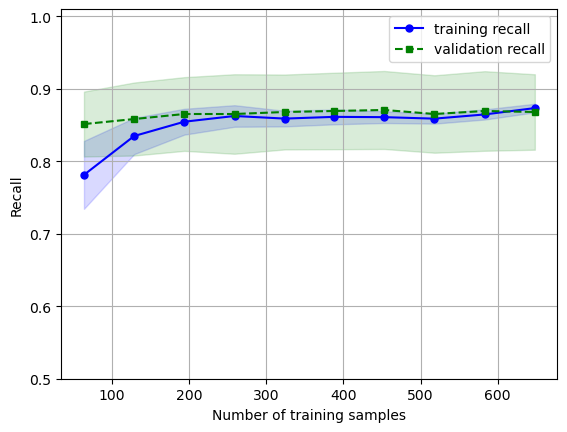

In [15]:
#Plot Learning Curve
print('Logisistic Regression - Learning Curve')
plot_learning_curves(pipe_logreg)

In [22]:
pip install mlxtend

  Using cached mlxtend-0.21.0-py2.py3-none-any.whl (1.3 MB)
Note: you may need to restart the kernel to use updated packages.


In [51]:
#Bias and Variance Trade-Off
from mlxtend.evaluate import bias_variance_decomp
from sklearn.preprocessing import LabelEncoder
encoder = LabelEncoder()
y_test = encoder.fit_transform(y_test)
y_train = encoder.fit_transform(y_train)

#Bias Variance Script
print('Bias Variance Trade-Off')
for name,method in[('Logistical Model',pipe_logreg)]:        
    avg_expected_loss, avg_bias, avg_var = bias_variance_decomp(
        method, x_train2, y_train, x_test2, y_test, 
        loss='0-1_loss',
        random_seed=100)
    print('\nEstimator: {}'.format(name)) 
    print('\nAverage Bias: {:.2f}'.format(avg_bias))
    print('Average Variance: {:.2f}'.format(avg_var))     

Bias Variance Trade-Off

Estimator: Logistical Model

Average Bias: 0.14
Average Variance: 0.01


Model Evaluation - Recall Weighted
Logistic Regression 0.87 +/- 0.04




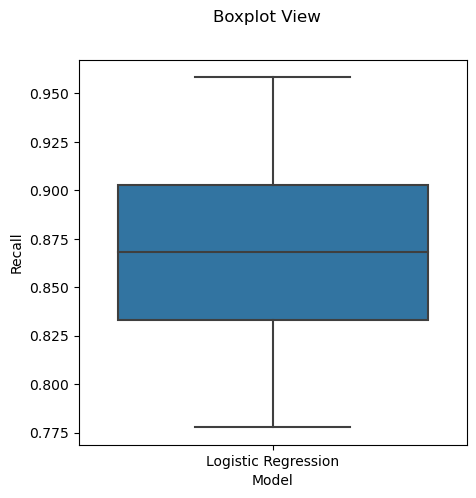

In [52]:
#Model Analysis
from sklearn.model_selection import RepeatedKFold
from sklearn.model_selection import cross_val_score

models=[]
models.append(('Logistic Regression',pipe_logreg))

#Model Evaluation
results =[]
names=[]
scoring ='recall_weighted'
print('Model Evaluation - Recall Weighted')
for name, model in models:
    rkf=RepeatedKFold(n_splits=10, n_repeats=5, random_state=100)
    cv_results = cross_val_score(model,x_train,y_train,cv=rkf,scoring=scoring)
    results.append(cv_results)
    names.append(name)
    print('{} {:.2f} +/- {:.2f}'.format(name,cv_results.mean(),cv_results.std()))
print('\n')

fig = plt.figure(figsize=(5,5))
fig.suptitle('Boxplot View')
ax = fig.add_subplot(111)
sns.boxplot(data=results)
ax.set_xticklabels(names)
plt.ylabel('Recall')
plt.xlabel('Model')
plt.show()

In [53]:
#Define Gridsearch Function

from sklearn.model_selection import GridSearchCV
from sklearn.metrics import classification_report, confusion_matrix  

def Gridsearch_cv(model, params):
    
    #Cross-validation Function
    cv2=RepeatedKFold(n_splits=10, n_repeats=5, random_state=100)
        
    #GridSearch CV
    gs_clf = GridSearchCV(model, params, cv=cv2,scoring='recall_weighted')
    gs_clf = gs_clf.fit(x_train, y_train)
    model = gs_clf.best_estimator_
    
    # Use best model and test data for final evaluation
    y_pred = model.predict(x_test)
    
    #Identify Best Parameters to Optimize the Model
    bestpara=str(gs_clf.best_params_)
    
    #Output Heading
    print('\nOptimized Model')
    print('\nModel Name:',str(pipeline.named_steps['clf']))
        
    #Output Validation Statistics
    target_names=['Outcome 0','Outcome 1']
    print('\nBest Parameters:',bestpara)
    print('\n', confusion_matrix(y_test,y_pred))  
    print('\n',classification_report(y_test,y_pred,target_names=target_names)) 
        
    #Transform the variables into binary (0,1) - ROC Curve
    from sklearn import preprocessing
    Forecast1=pd.DataFrame(y_pred)
    Outcome1=pd.DataFrame(y_test)
    lb1 = preprocessing.LabelBinarizer()
    OutcomeB1 =lb1.fit_transform(Outcome1)
    ForecastB1 = lb1.fit_transform(Forecast1)
    
    #Setup the ROC Curve
    from sklearn.metrics import roc_curve, auc
    from sklearn import metrics
    fpr, tpr, threshold = metrics.roc_curve(OutcomeB1, ForecastB1)
    roc_auc = metrics.auc(fpr, tpr)
    print('ROC Curve')
    #Plot the ROC Curve
    plt.title('Receiver Operating Characteristic')
    plt.plot(fpr, tpr, 'b', label = 'AUC = %0.2f' % roc_auc)
    plt.legend(loc = 'lower right')
    plt.plot([0, 1], [0, 1],'r--')
    plt.xlim([0, 1])
    plt.ylim([0, 1])
    plt.ylabel('True Positive Rate')
    plt.xlabel('False Positive Rate')
    plt.show()  


Optimized Model

Model Name: LogisticRegression(class_weight='balanced', random_state=100)

Best Parameters: {'clf__C': 0.01, 'clf__penalty': 'l2'}

 [[73 17]
 [12 78]]

               precision    recall  f1-score   support

   Outcome 0       0.86      0.81      0.83        90
   Outcome 1       0.82      0.87      0.84        90

    accuracy                           0.84       180
   macro avg       0.84      0.84      0.84       180
weighted avg       0.84      0.84      0.84       180

ROC Curve


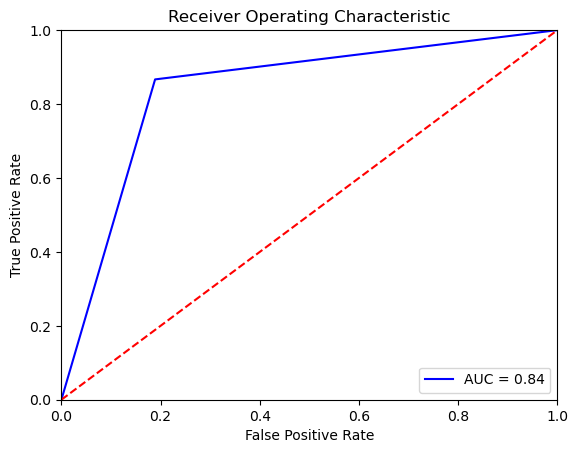

In [54]:
#Run Models

for pipeline, modelpara in zip(pipeline,modelpara):
    Gridsearch_cv(pipeline,modelpara)

In [57]:
#Next Steps - Feature Selection using SelectFromModel
from sklearn.feature_selection import SelectFromModel
clf = LogisticRegression(solver='lbfgs',class_weight='balanced',
                                            random_state=100)
clf.fit(x_train2,y_train)
model = SelectFromModel(clf, prefit=True)
feature_idx = model.get_support()
feature_name = RD.drop('Class',axis=1).columns[feature_idx]
print('\nKey Features:',feature_name)


Key Features: Index(['Area', 'Perimeter'], dtype='object')
